In [2]:
import cobra
from plotting_functions import substrate_name_to_rxn, plot_theoretical_yields

%matplotlib inline

In [3]:
model = cobra.io.load_json_model('iML1515.json')

In [6]:
def run_and_plot_simulations(cons_model, target_rxn, aerobic=True):
    yield_list = []
    substrate_list = []
    rxn_count = []
    if target_rxn.startswith("EX_"):
        target_met = target_rxn.replace('EX_', '')
        
    for met, met_id in substrate_name_to_rxn.items():

        model.objective = target_rxn
        model.reactions.ATPM.lower_bound = 0
        model.reactions.EX_o2_e.lower_bound = -1000 if aerobic else 0
        model.reactions.EX_glc__D_e.lower_bound = 0

        model.reactions.get_by_id(met_id).lower_bound = -10
        sol = cobra.flux_analysis.pfba(model)

        if sol.x_dict['EX_co2_e'] < -1e-4:
            co2_correction = abs(sol.x_dict['EX_co2_e']) *\
                             model.metabolites.co2_e.elements['C']
            print(met, sol.x_dict['EX_co2_e'])
        else:
            co2_correction = 0

        model.reactions.get_by_id(met_id).lower_bound = 0

        if abs(sol.f) < .001 or abs(sol.x_dict[met_id]) < .001:
            rxn_count.append(0)
            yield_list.append(0)
            substrate_list.append(met)

            continue
        
        if target_rxn not in ['ATPM', model.reactions.BIOMASS_Ec_iML1515_core_75p37M.id]:

            carbon_yield = (sol.f * model.metabolites.get_by_id(target_met).elements['C'] - co2_correction) / \
                           (abs(sol.x_dict[met_id]) * model.metabolites.get_by_id(
                               met_id.replace('EX_', '')).elements['C'])
        else:
            carbon_yield = sol.f / (abs(sol.x_dict[met_id]) * model.metabolites.get_by_id(
                               met_id.replace('EX_', '')).elements['C'])

        count = 0
        for r, v in sol.x_dict.items():
            if abs(v) > 1e-6:
                count += 1

        rxn_count.append(count)
        yield_list.append(carbon_yield)
        substrate_list.append(met)

    plot_theoretical_yields(yield_list, substrate_list, 'Histidine', rxn_count)


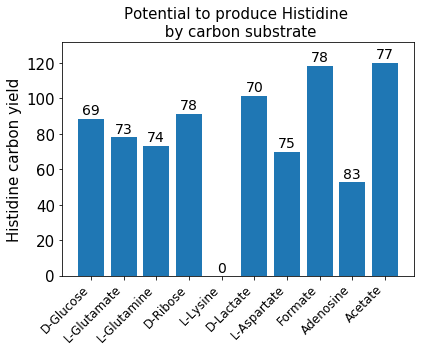

In [7]:
run_and_plot_simulations(model, 'EX_his__L_e', aerobic=True)

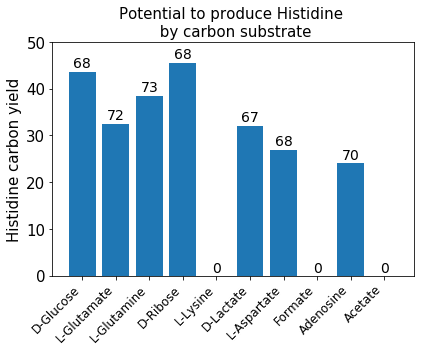

In [8]:
run_and_plot_simulations(model, 'EX_his__L_e', aerobic=False)

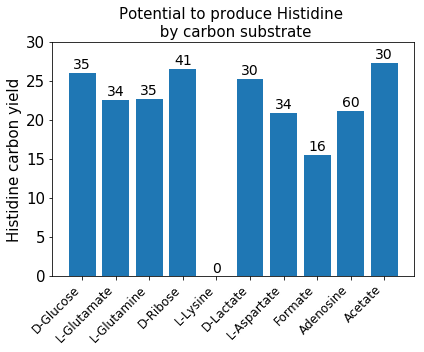

In [9]:
run_and_plot_simulations(model, 'ATPM', aerobic=True)

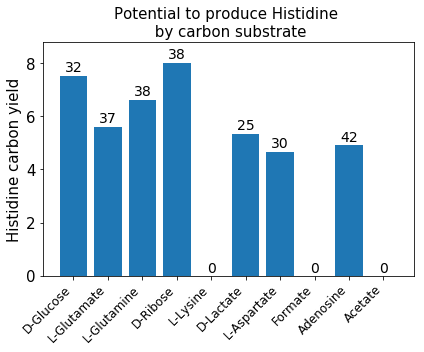

In [10]:
run_and_plot_simulations(model, 'ATPM', aerobic=False)

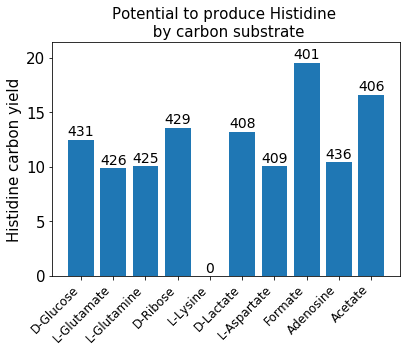

In [11]:
run_and_plot_simulations(model, model.reactions.BIOMASS_Ec_iML1515_core_75p37M.id, aerobic=True)

D-Glucose -0.07972457023327631
D-Ribose -0.034547313766963045
D-Lactate -0.007390630328473946


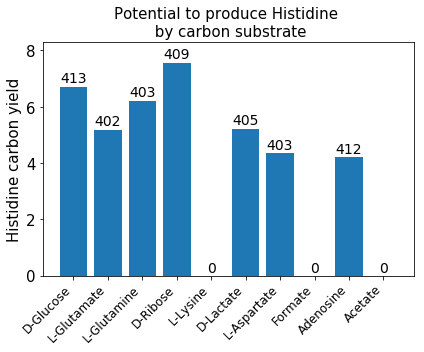

In [12]:
run_and_plot_simulations(model, model.reactions.BIOMASS_Ec_iML1515_core_75p37M.id, aerobic=False)